# Pretrain Policy with  `MPC dataset`

In [1]:
import numpy as np
import pickle
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from mujoco_parser import MuJoCoParserClass
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from policy import GaussianPolicy
from motion_vae import MotionVariationalAutoEncoderClass

### Load  `MPC dataset`

In [2]:
with open(file='../data/MPC_dataset_240324_bigggger_noise-2.pkl', mode='rb') as f:
    dataset = pickle.load(f)

horizon = 50
action = torch.Tensor(dataset['action'])
root_pos = torch.Tensor(dataset['root_pos'])
root_rot = torch.Tensor(dataset['root_rot'])
root_vel = torch.Tensor(dataset['root_vel'])
root_ang_vel = torch.Tensor(dataset['root_ang_vel'])
dof_pos = torch.Tensor(dataset['dof_pos'])
dof_vel = torch.Tensor(dataset['dof_vel'])
local_key_pos = torch.Tensor(dataset['local_key_pos'])

del dataset

# qpos_batch = qpos_batch[:, :]
# qpos_batch = torch.cat((qpos_batch[:-2, :],qpos_batch[1:-1, :],qpos_batch[2:, :]),dim=1)
# qvel_batch = torch.cat((qvel_batch[:-2, :],qvel_batch[1:-1, :],qvel_batch[2:, :]),dim=1)

obs = torch.cat((root_pos, root_rot, root_vel, root_ang_vel, dof_pos, dof_vel, local_key_pos.reshape(-1, 12)), dim=1)
# obs = torch.cat((root_pos, root_rot, root_vel, root_ang_vel, dof_pos, dof_vel), dim=1)

# action_batch = action_batch[2:]
obs_dim = obs.shape[1]
action_dim = action.shape[1]
hidden_dim = 512

print("obs : ", obs.shape)
print("action : ", action.shape)


obs :  torch.Size([15750, 99])
action :  torch.Size([15750, 37])


In [3]:
xml_path = '../asset/smpl_rig/scene_smpl_rig.xml'
env = MuJoCoParserClass(name='smplrig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0083] HZ:[120]
n_dof (=nv):[43]
n_geom:[67]
geom_names:['floor', 'base', 'base2lpelvis', 'base2rpelvis', 'base2spine1', 'spine2spine', 'spine2spine2', 'spine2spine3', 'spine2lcollar', 'spine2rcollar', 'neck2head', 'head', 'nose', 'lcollar2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2lindex1', 'lwrist2lmiddle1', 'lwrist2lpinky1', 'lwrist2lring1', 'lwrist2lthumb1', 'lindex1-lindex2', 'lindex2-lindex3', 'lindex3-lindextip', 'lmiddle1-lmiddle2', 'lmiddle2-lmiddle3', 'lmiddl3-lmiddletip', 'lring1-lring2', 'lring2-lring3', 'lring3-lringtip', 'lpinky1-lpinky2', 'lpinky2-lpinky3', 'lpinky3-lpinkytip', 'lthumb1-lthumb2', 'lthumb2-lthumb3', 'lthumb3-lthumbtip', 'rcollar2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rindex1', 'rwrist2rmiddle1', 'rwrist2rpinky1', 'rwrist2rring1', 'rwrist2rthumb1', 'rindex1-rindex2', 'rindex2-rindex3', 'rindex3-rindextip', 'rmiddle1-rmiddle2', 'rmiddle2-rmiddle3', 'rmiddle3-rmiddletip', 'rring1-rring2', 'rring2-rring3', 'rring3-rringtip

In [4]:
# policy = GaussianPolicy(
#     input_dim=obs_dim,
#     output_dim=action_dim,
#     hidden_dim=hidden_dim,
#     is_deterministic=False,
# )

hidden_dim = 512

world_model = GaussianPolicy(
    input_dim=obs_dim+action_dim,
    output_dim=obs_dim-12, # exclude key body pos
    hidden_dim=hidden_dim,
    is_deterministic=False,
)

MotionVAEPolicy = MotionVariationalAutoEncoderClass(
    name     = 'C-VAE-MPC',
    x_dim    = obs_dim,
    y_dim    = action_dim,
    c_dim    = 10,
    z_dim    = 32,
    h_dims   = [256,256],
    actv_enc = nn.ReLU(),
    actv_dec = nn.ReLU(),
    actv_out = None,
    var_max  = 0.1,
    device   ='cpu',
    )

RunningMeanStd:  99


In [5]:
class MPCDataset(Dataset):
    def __init__(self, obs, act):
        # self.obs = obs
        # self.obs = (self.obs - self.obs.mean(dim=0)) / self.obs.std(dim=0)
        self.act = act[:-1] * env.model.actuator_gear[:, 0]
        # self.act = (self.act - self.act.mean(dim=0)) / self.act.std(dim=0)
        self.next_obs = obs[1:]
        self.obs = obs[:-1]

        assert self.obs.shape[0] == self.act.shape[0]

    def __len__(self):
        return self.obs.shape[0]

    def __getitem__(self,idx):
        return torch.cat((self.obs[idx], self.next_obs[idx])), self.act[idx]

In [7]:
train_dataset = MPCDataset(obs, action)
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
policy.last_fc_log_std.weight

NameError: name 'policy' is not defined

In [8]:
num_epoch = 1000
optimizer = optim.Adam(policy.parameters(), lr=1e-5, eps=1e-10, betas=(0.9, 0.95))
loss = torch.nn.MSELoss()
def criterion(output: torch.tensor, y: torch.tensor, mean, std, log_prob):
    diff = output - y

    normal = Normal(mean, std)
    GT_neglogp = -normal.log_prob(y)

    logp_error = torch.mean(GT_neglogp)
    logp_coeff = 1e-2
    pred_error = (torch.mean(torch.abs(diff)))

    return pred_error + logp_error * logp_coeff
    # return torch.mean(torch.sqrt(torch.mean(torch.square(diff),dim=1)))
    # return loss(output, y)

policy.train()
policy.running_mean_std.train()
# policy.action_mean_std.train()
for epoch in range(num_epoch):

    with tqdm(train_dataloader, unit="batch") as tepoch:
        
        for x, y in tepoch:
            
            tepoch.set_description(f"Epoch {epoch+1}")

            optimizer.zero_grad()
                
            pred, mean, std, log_prob = policy(x) # supervised
            l = criterion(pred, y, mean, std, log_prob)
            l.backward()
            optimizer.step()
            
            tepoch.set_postfix(loss=l.item())


Epoch 1000: 100%|██████████| 8/8 [00:00<00:00, 36.14batch/s, loss=0.265]


### Test pretrain model

In [9]:
PLOT = True
policy.eval()
policy.running_mean_std.eval()
policy.is_deterministic = True

In [7]:
LOAD = True
if LOAD:
    file_path = "240312_walk_keypos.pth"
    policy.load_state_dict((torch.load(file_path)))

In [10]:
# Set which joints to control
ctrl_joint_names = env.ctrl_joint_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

/var/folders/xg/3z5dsdd15r74bw6d3yb9_0zw0000gp/T/ipykernel_78820/3969561233.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

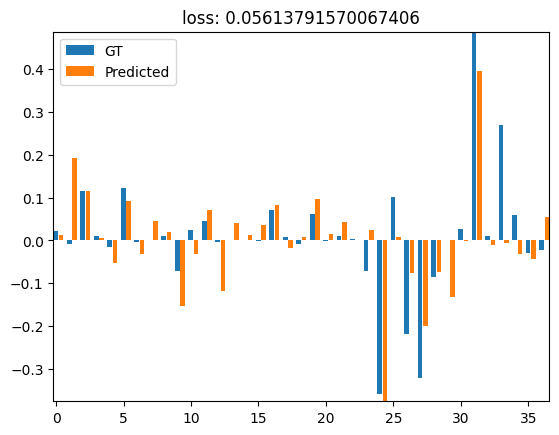

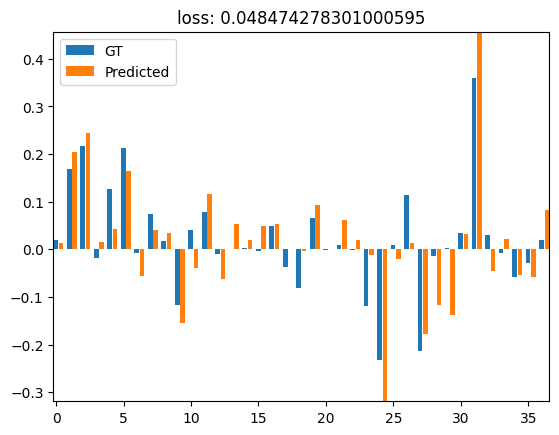

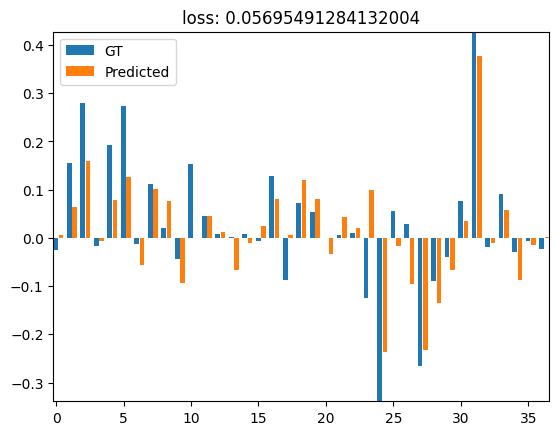

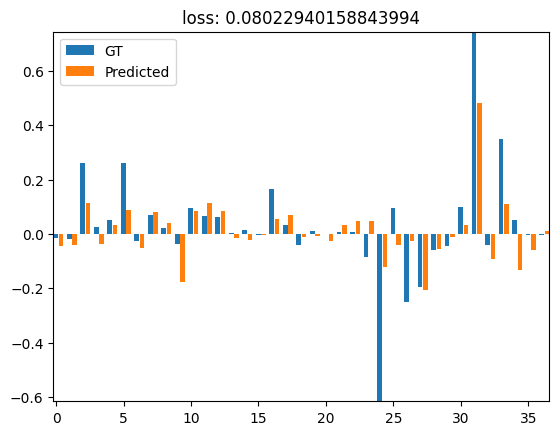

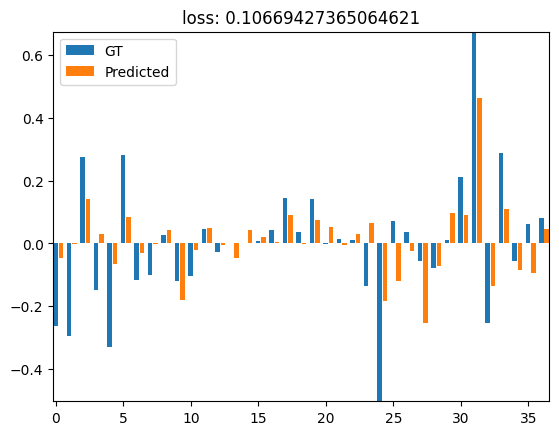

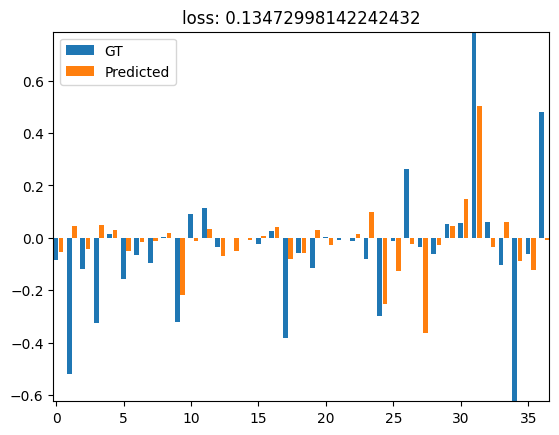

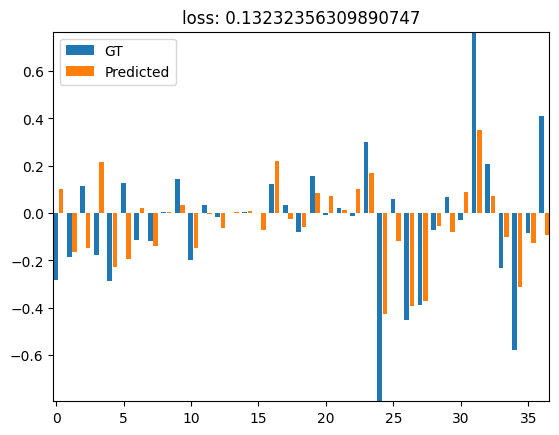

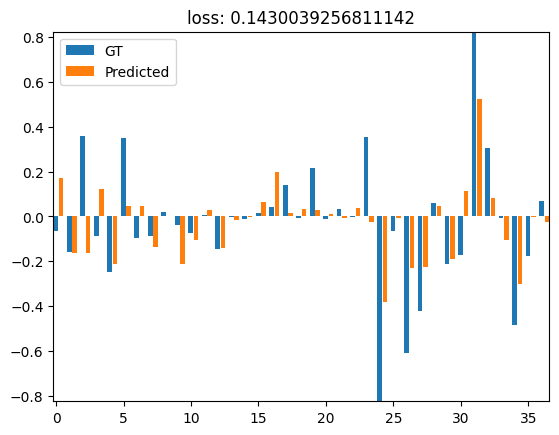

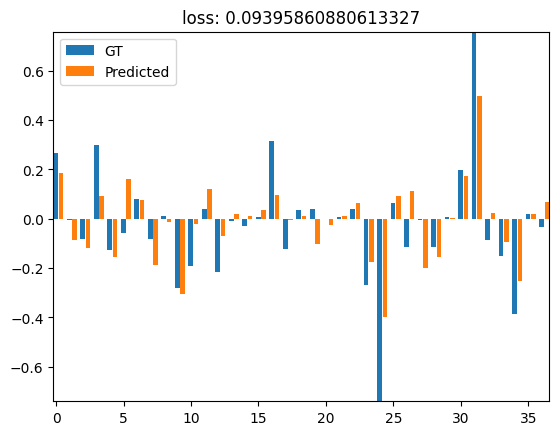

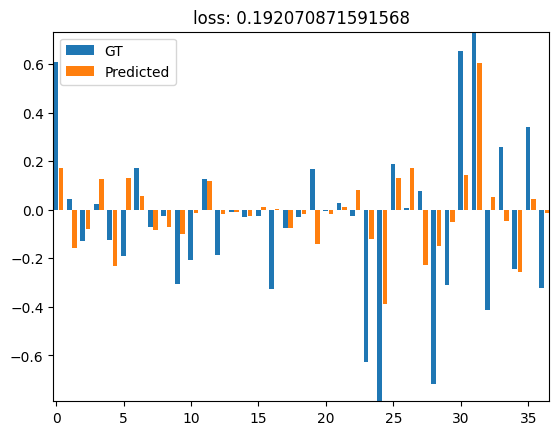

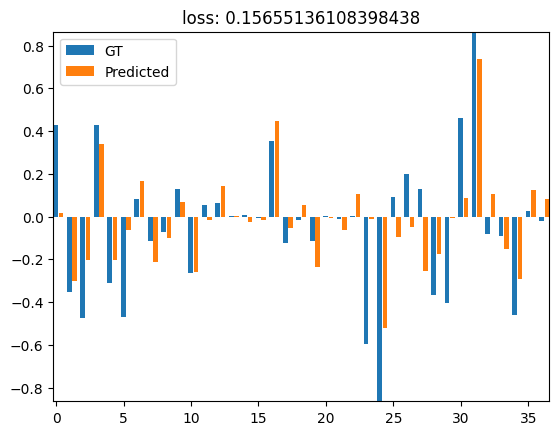

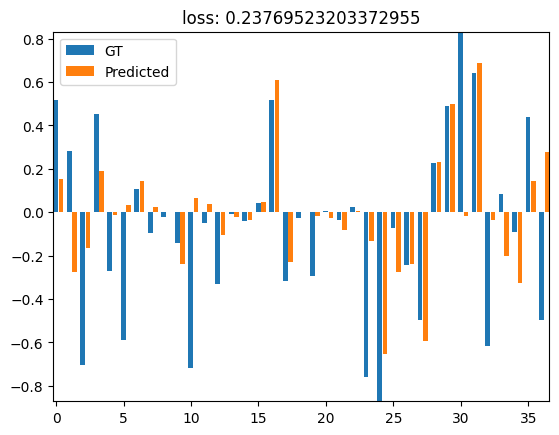

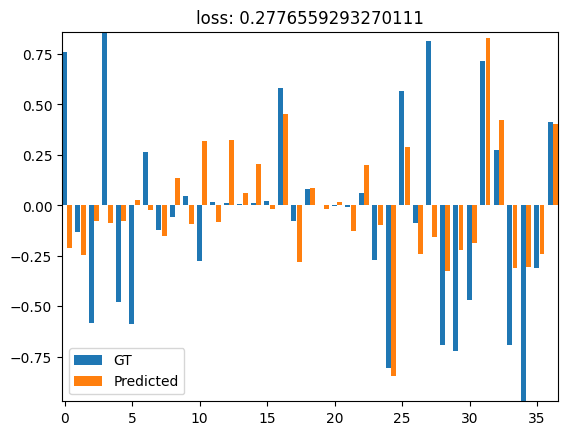

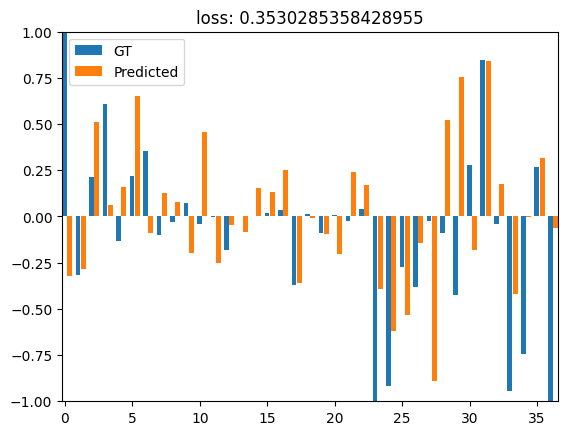

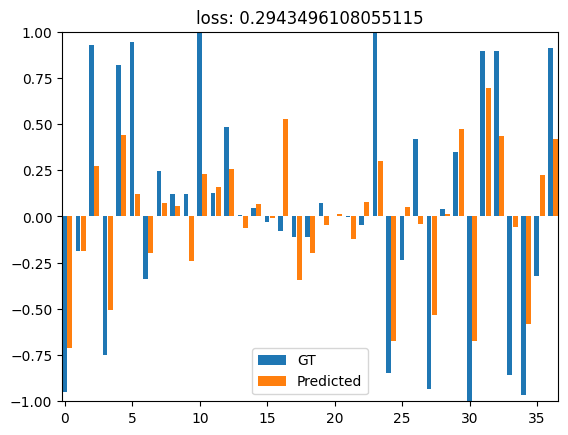

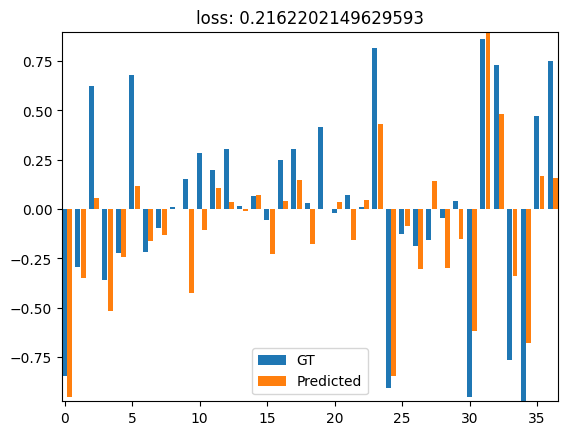

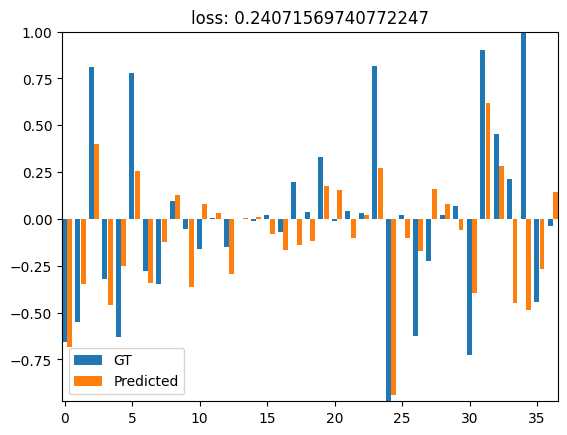

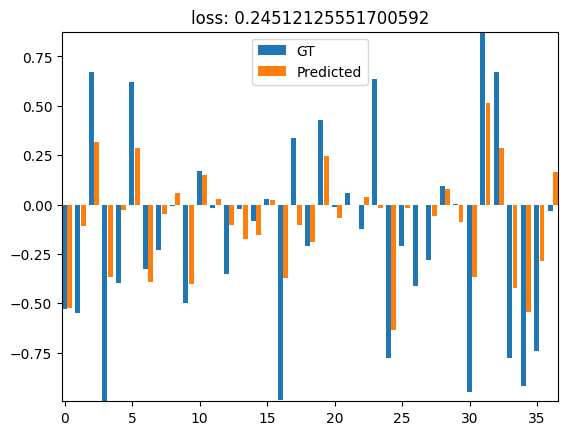

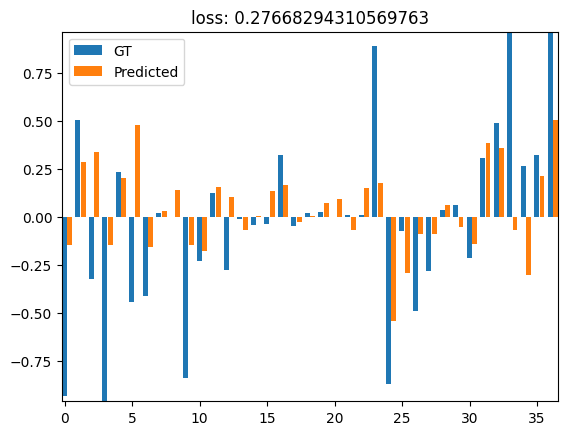

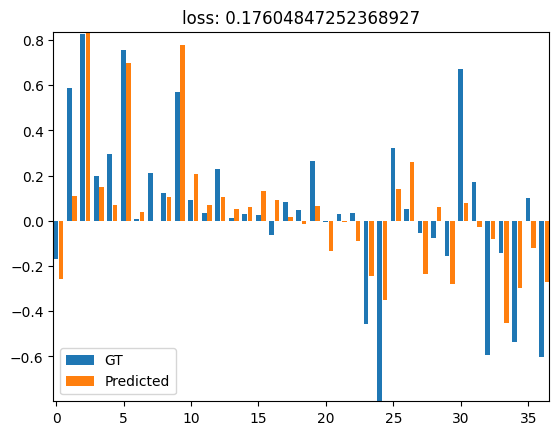

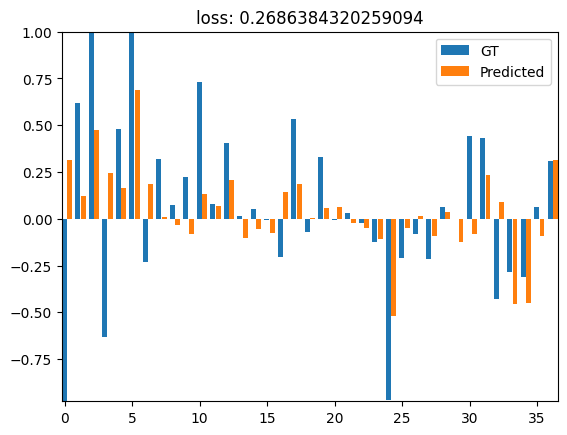

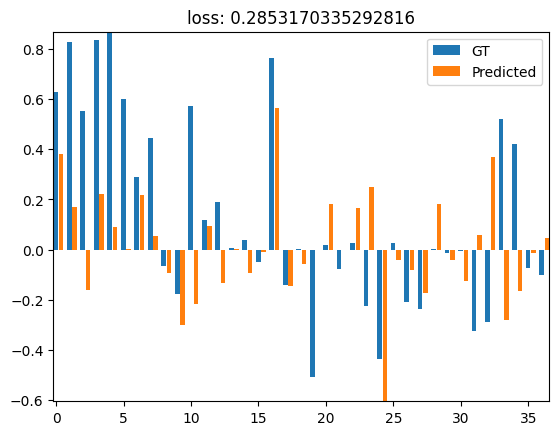

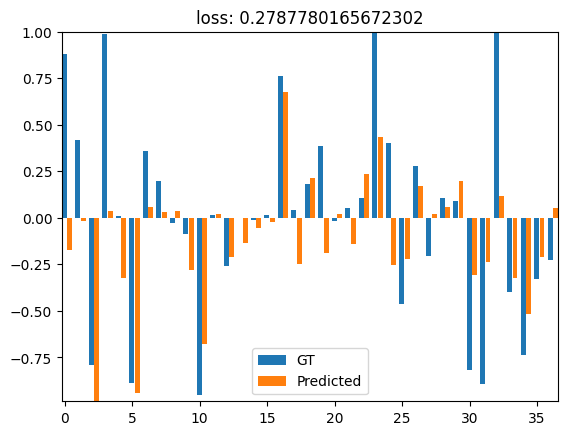

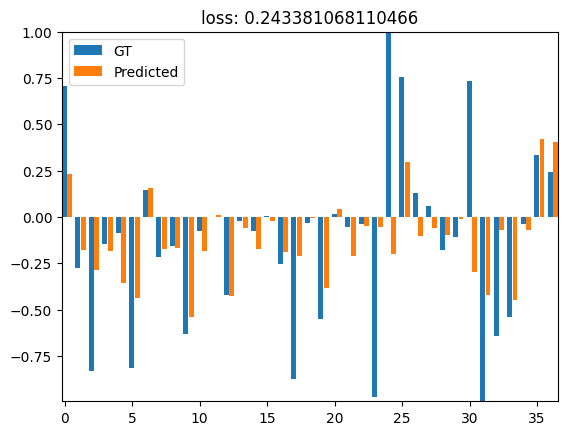

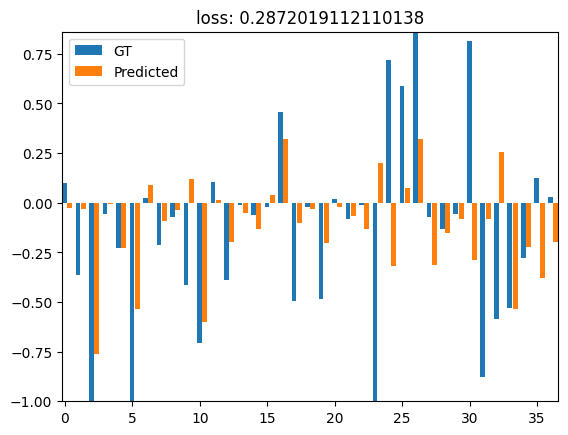

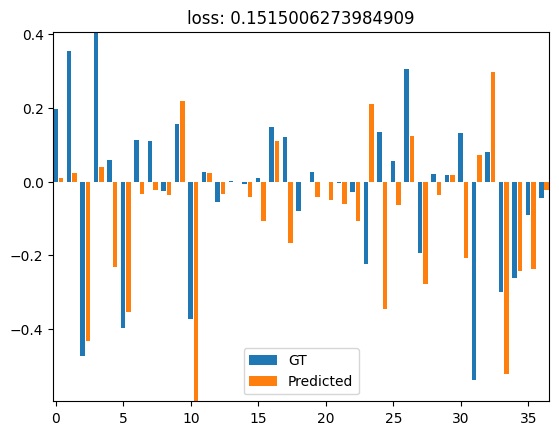

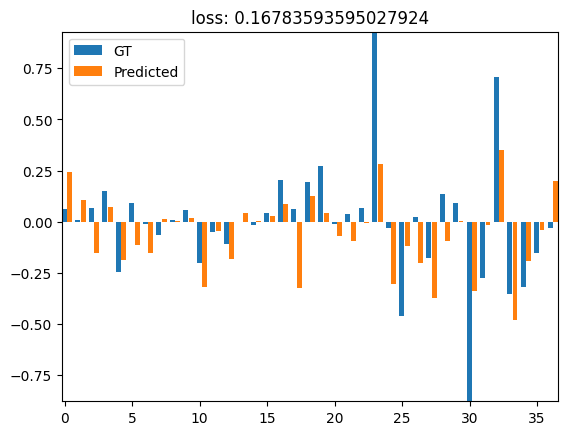

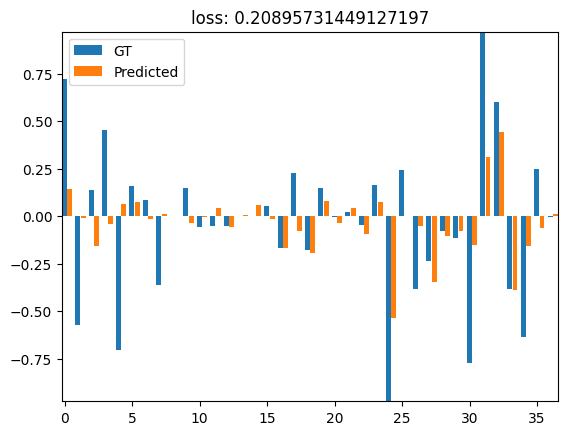

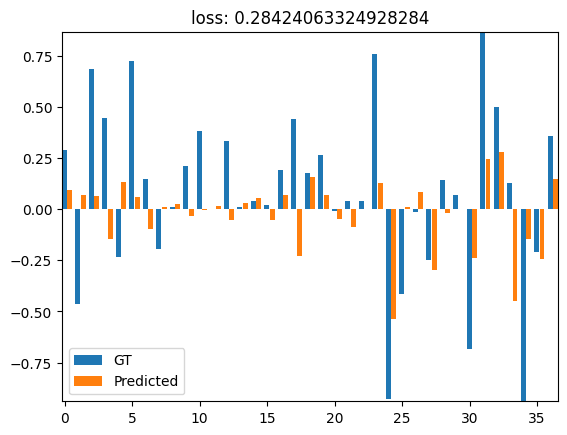

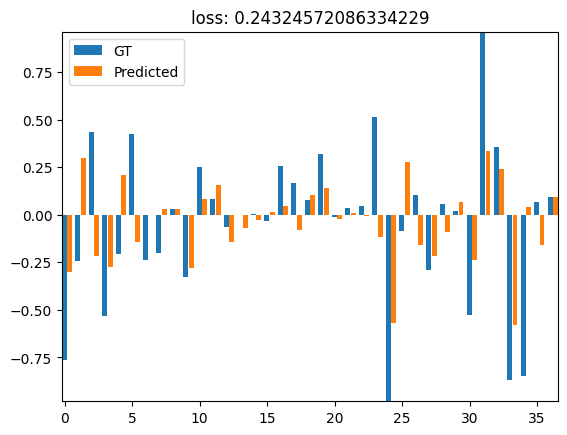

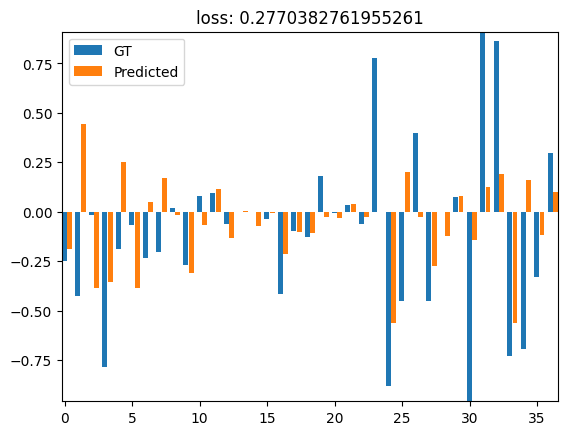

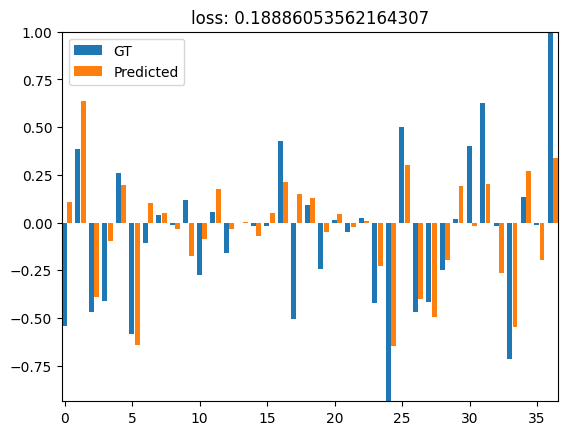

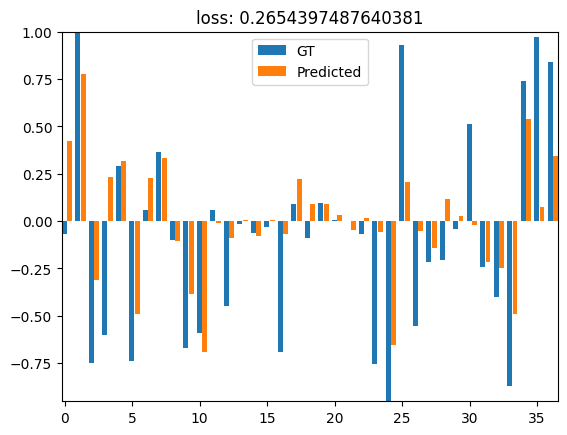

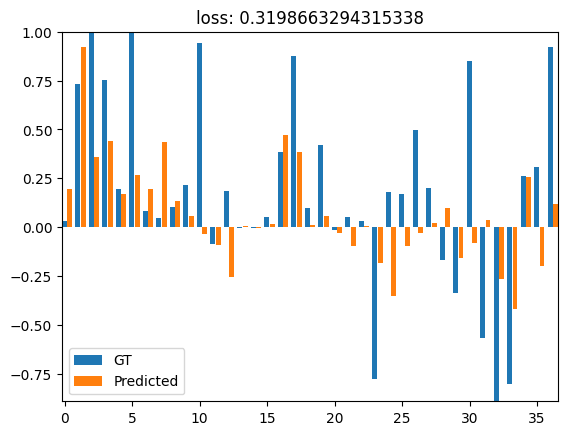

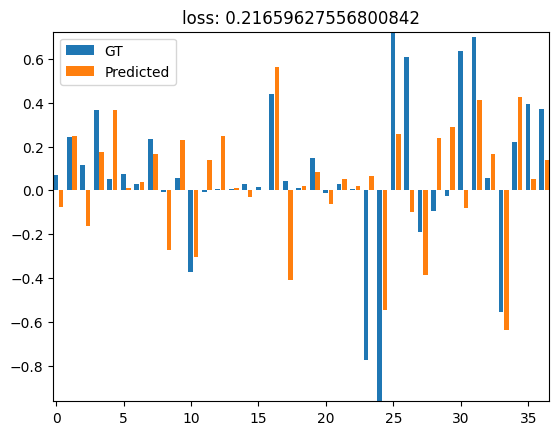

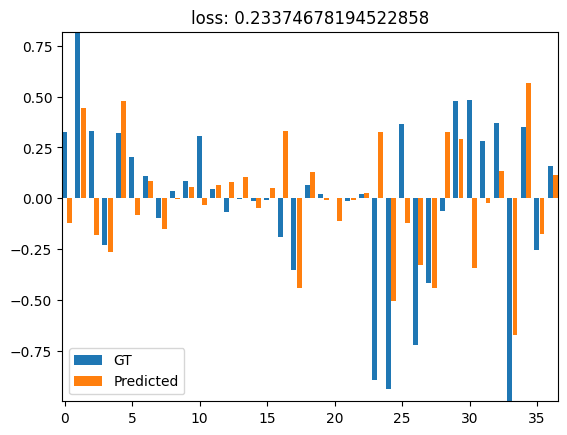

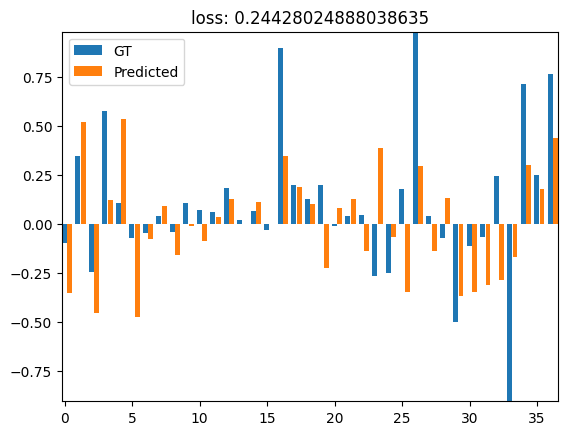

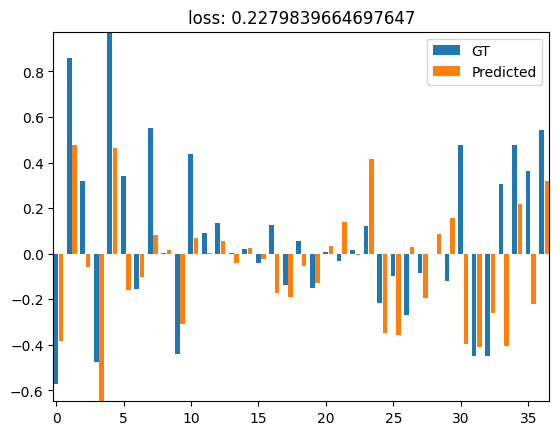

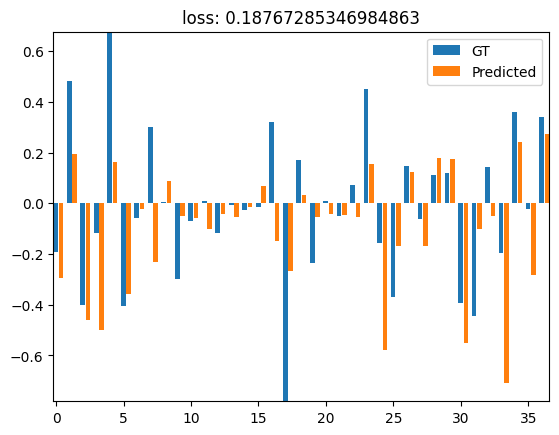

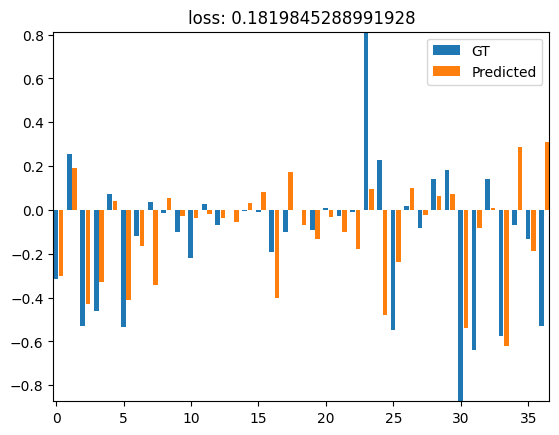

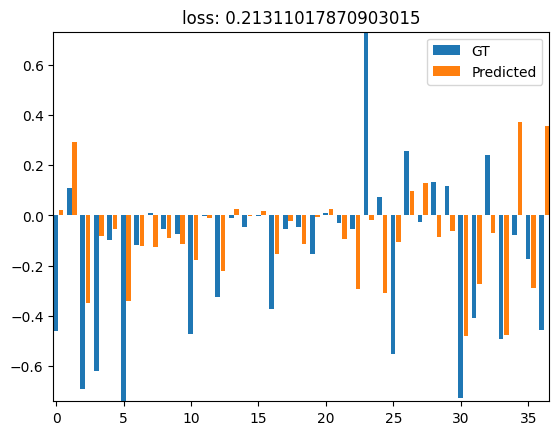

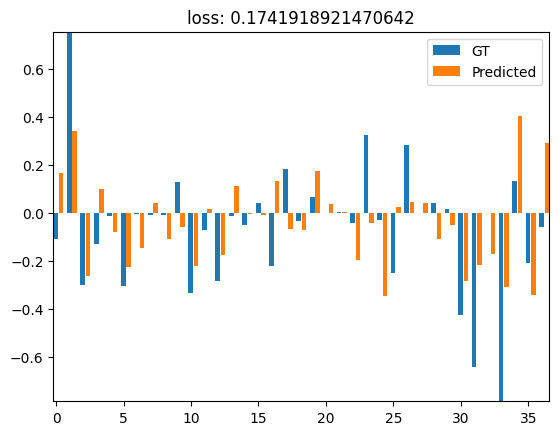

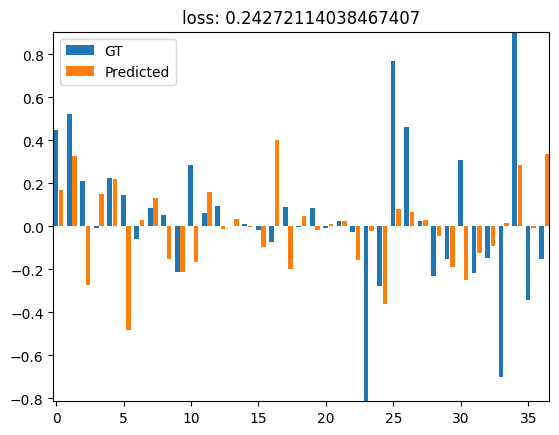

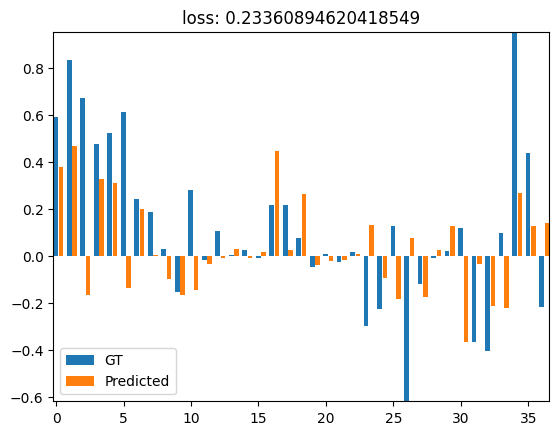

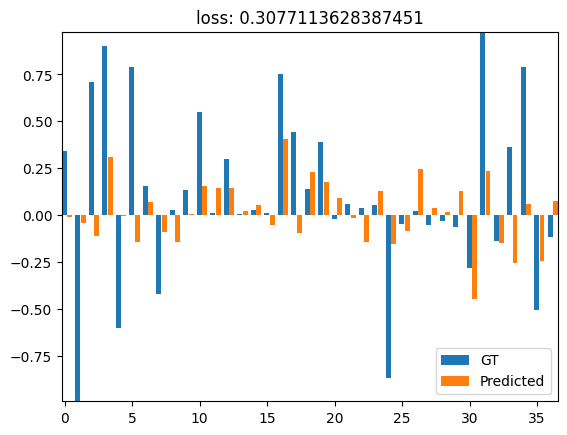

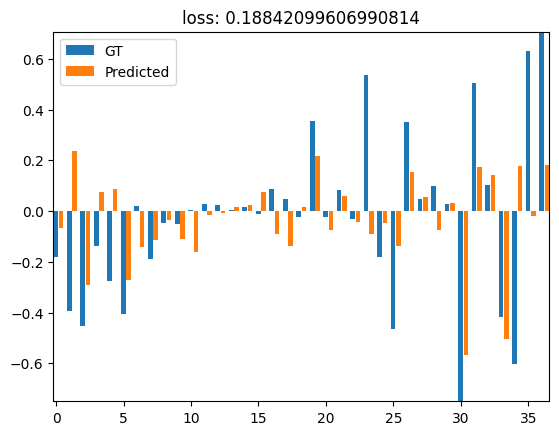

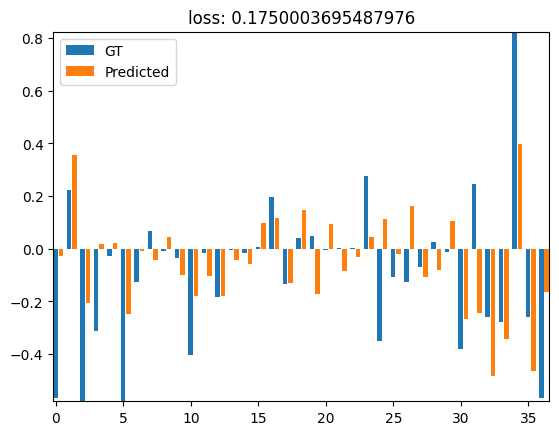

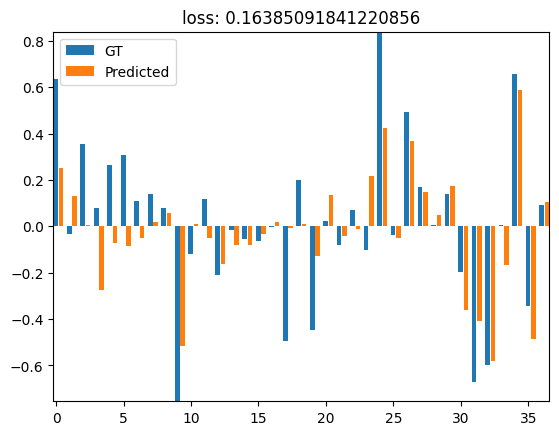

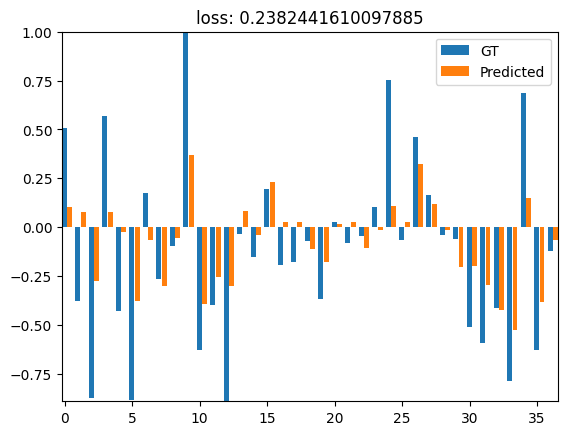

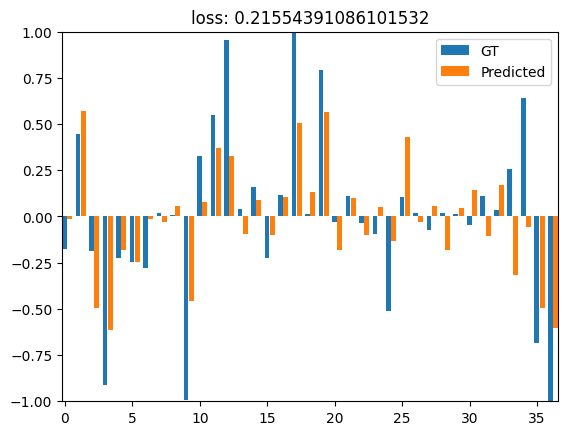

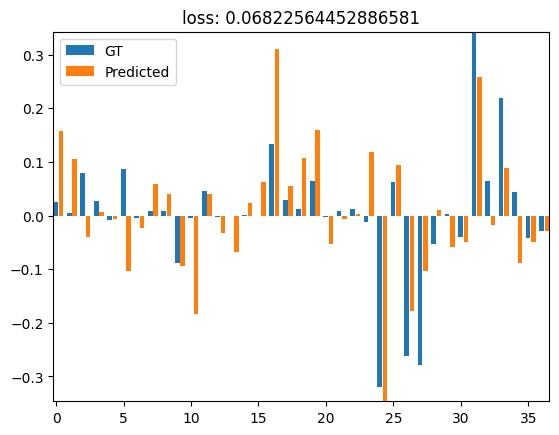

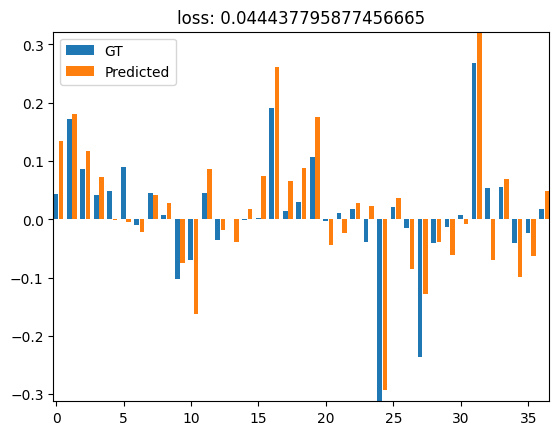

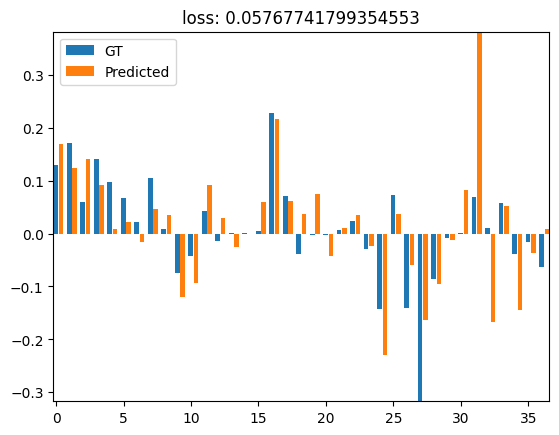

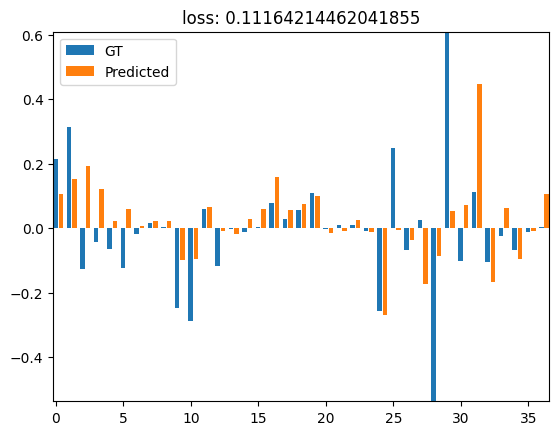

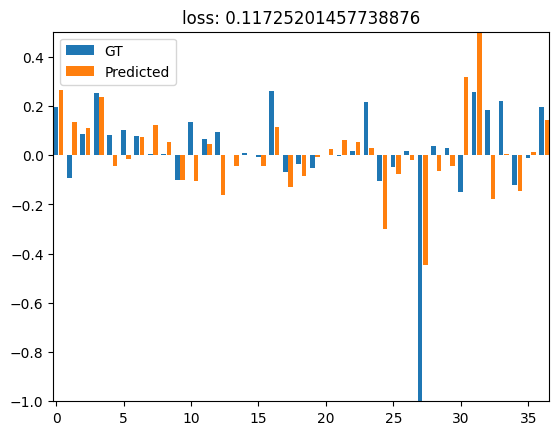

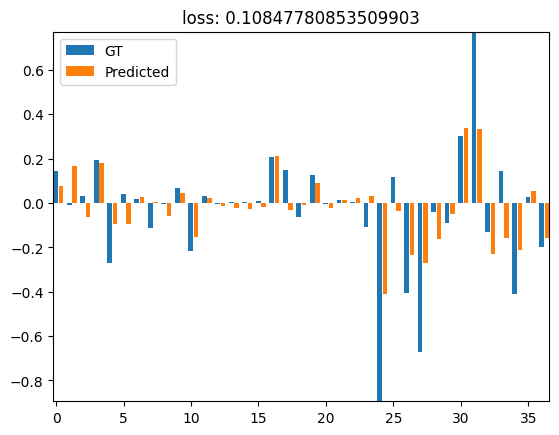

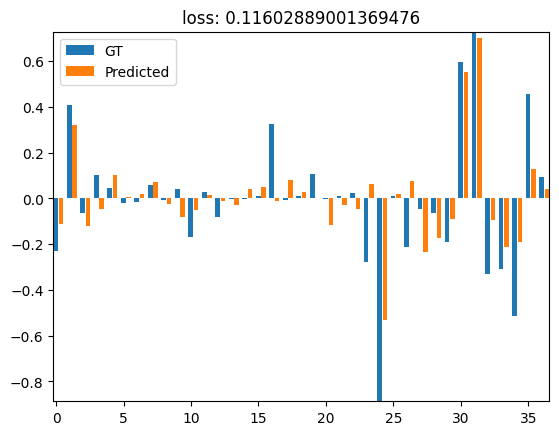

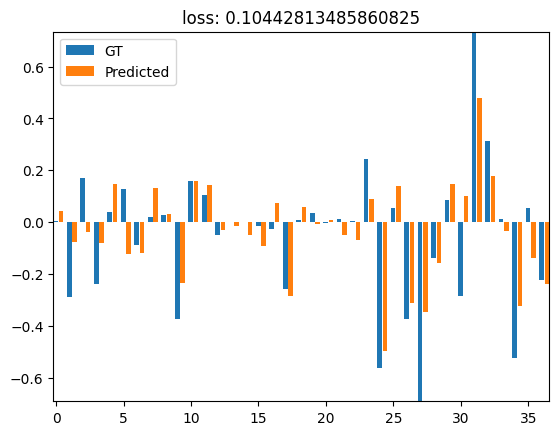

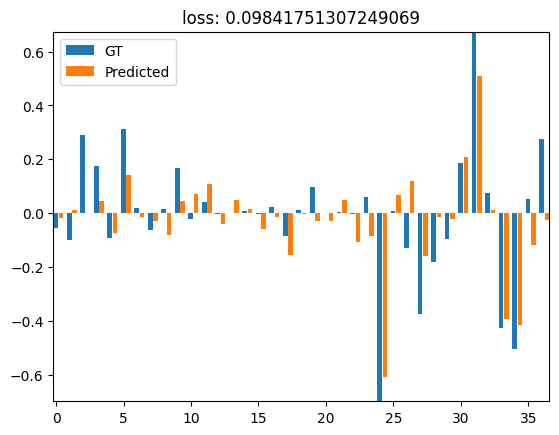

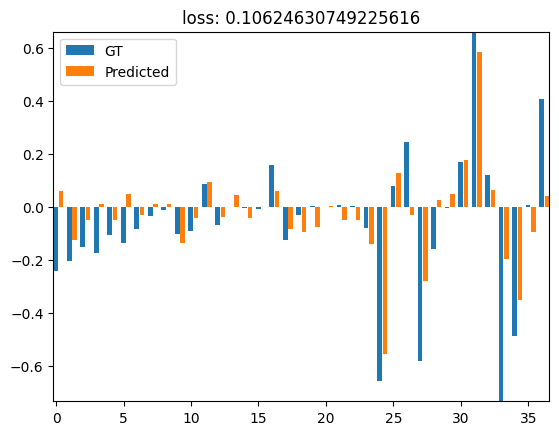

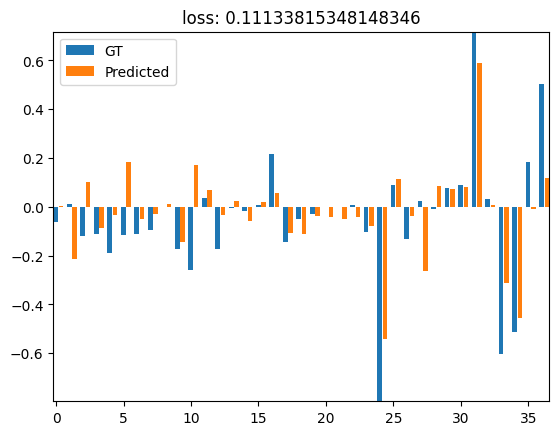

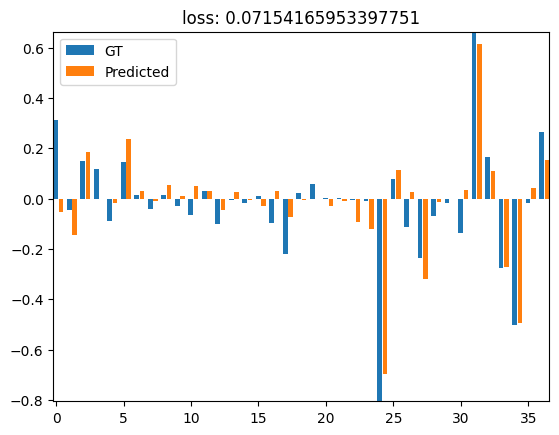

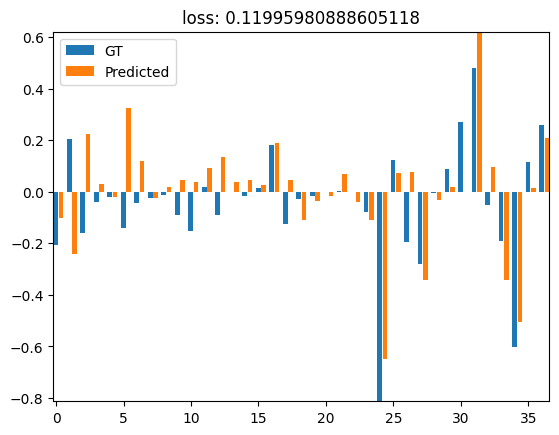

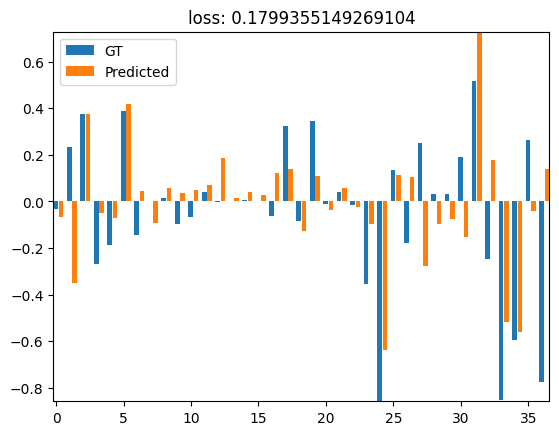

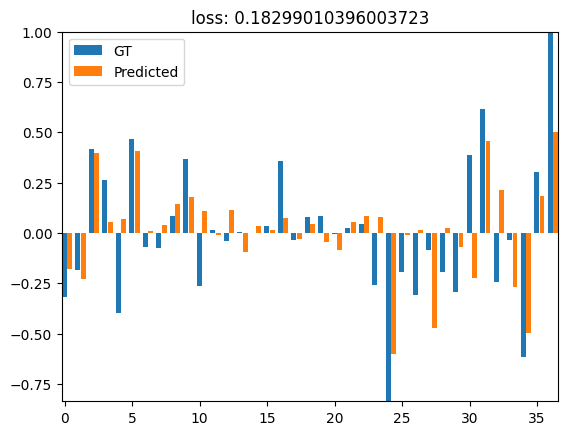

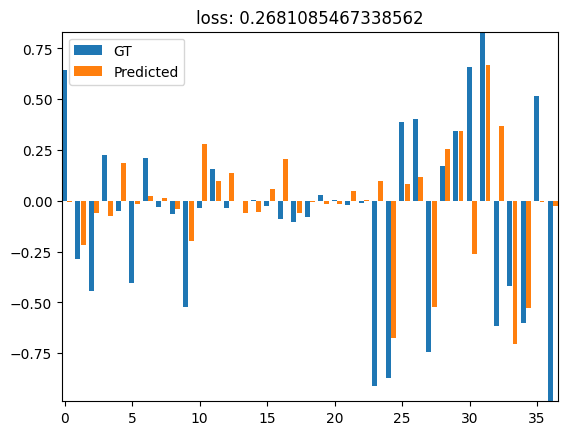

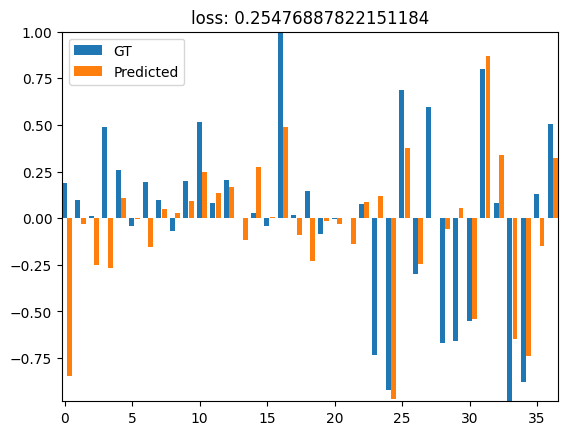

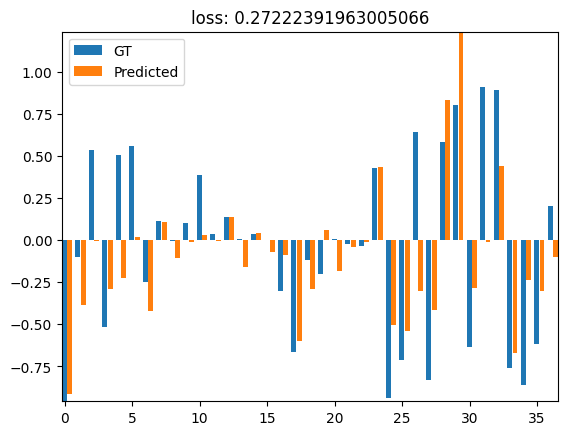

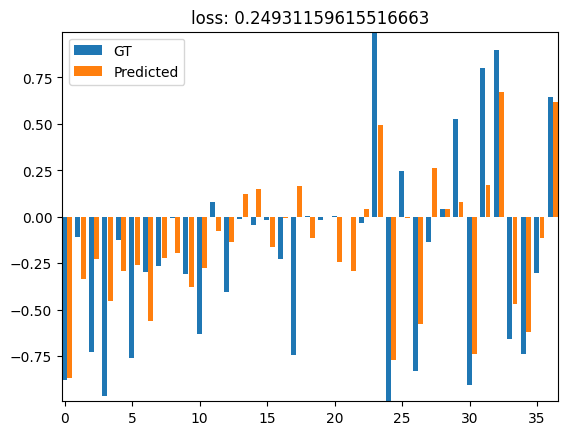

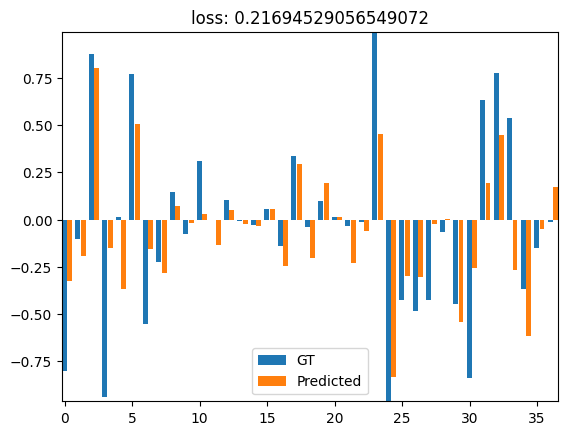

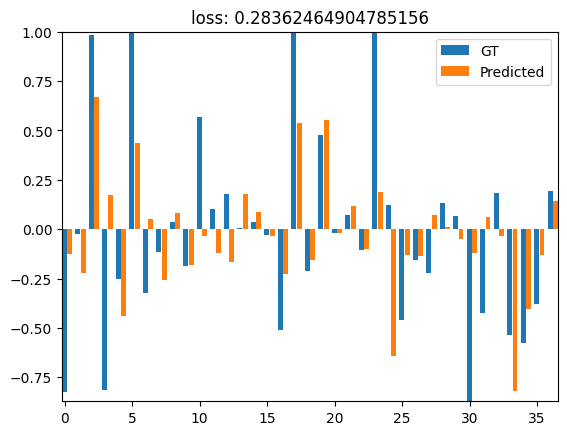

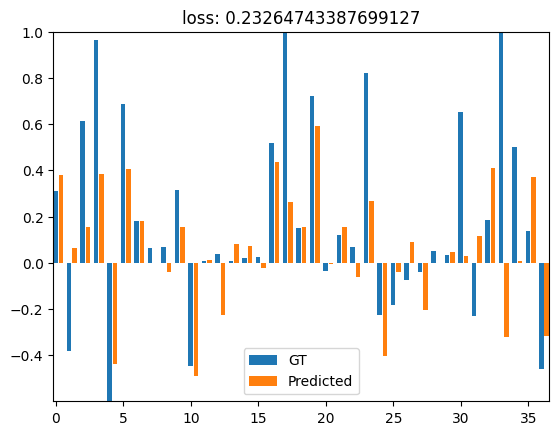

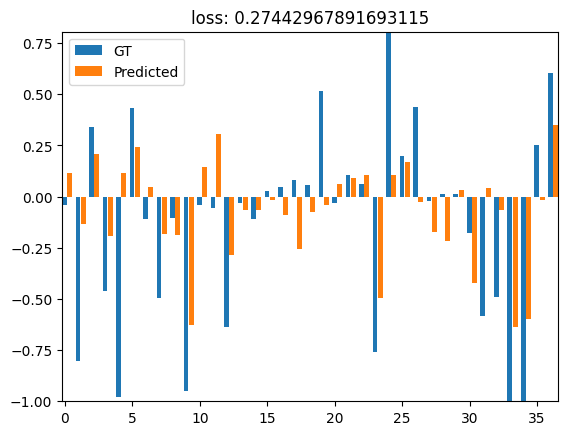

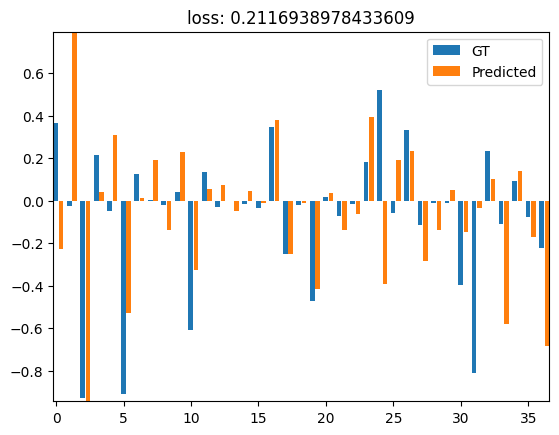

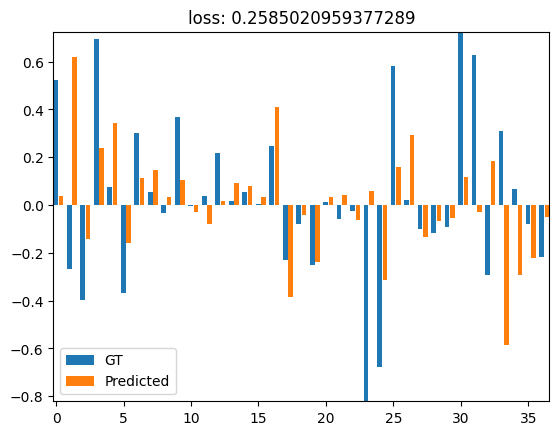

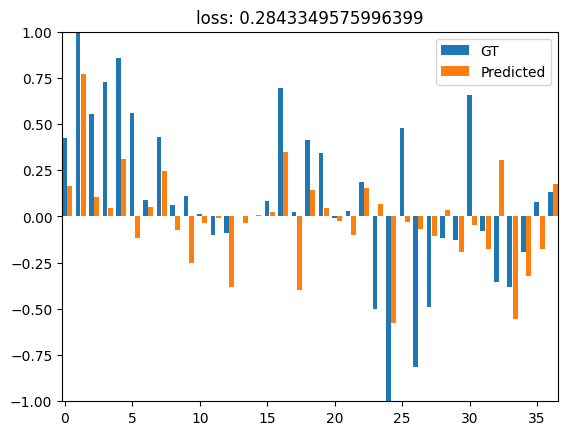

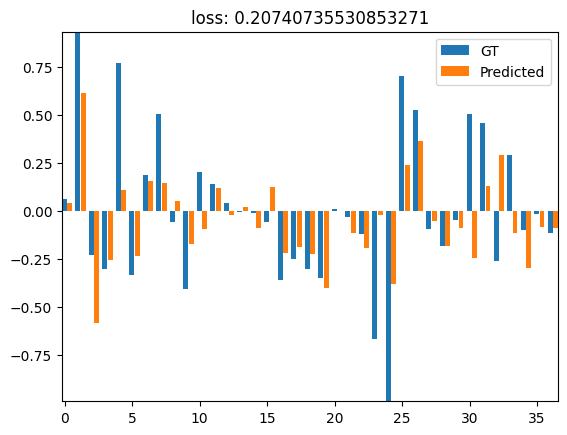

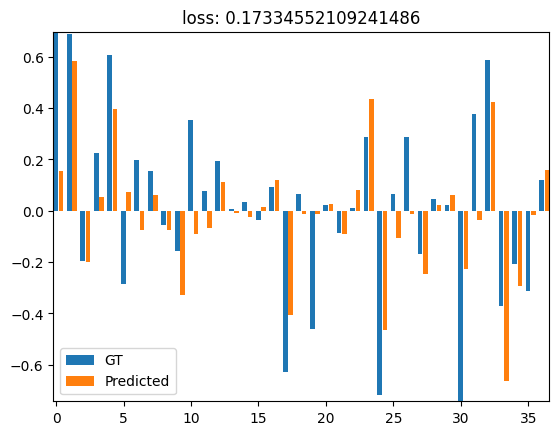

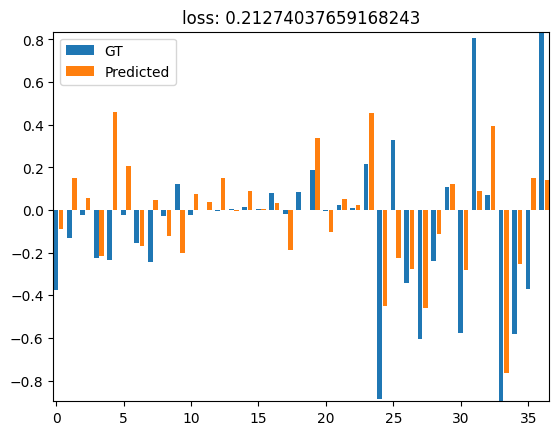

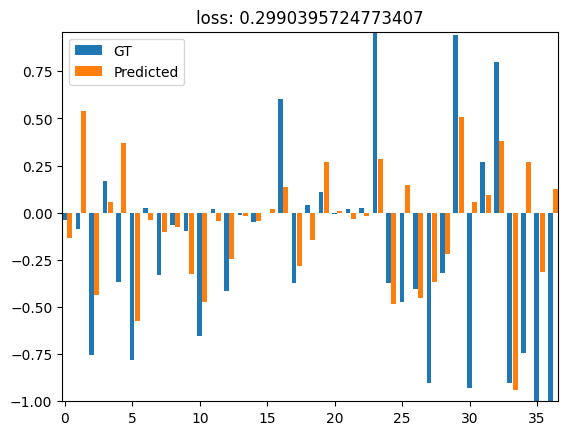

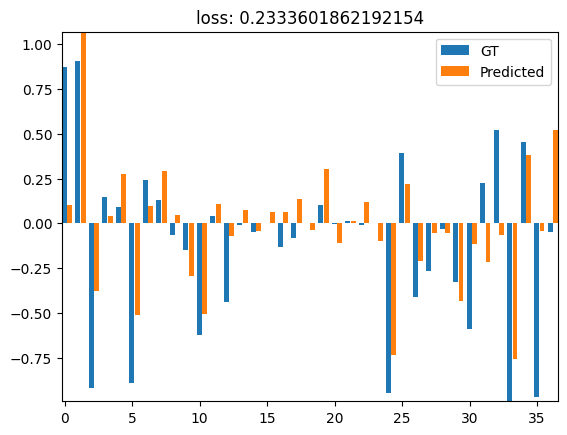

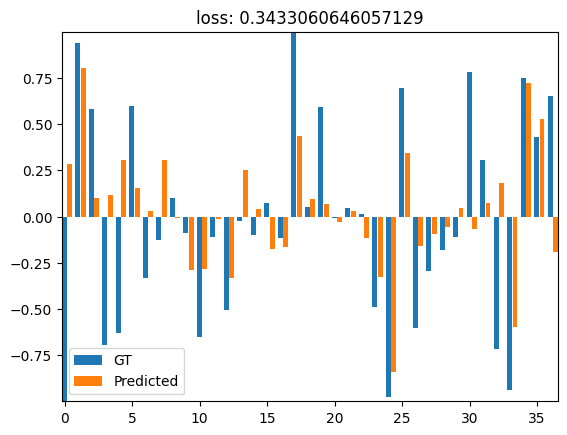

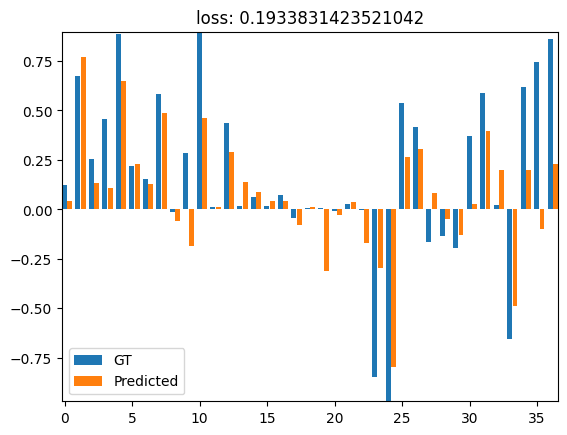

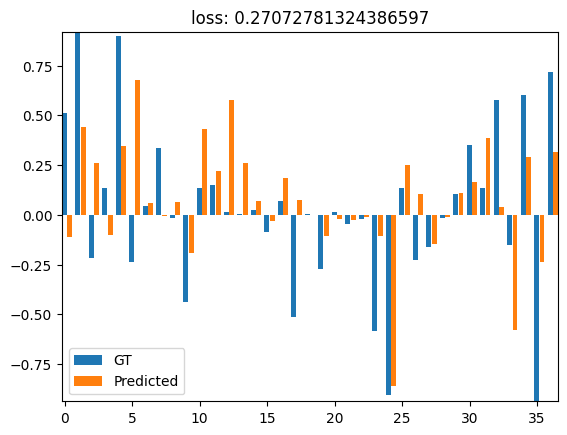

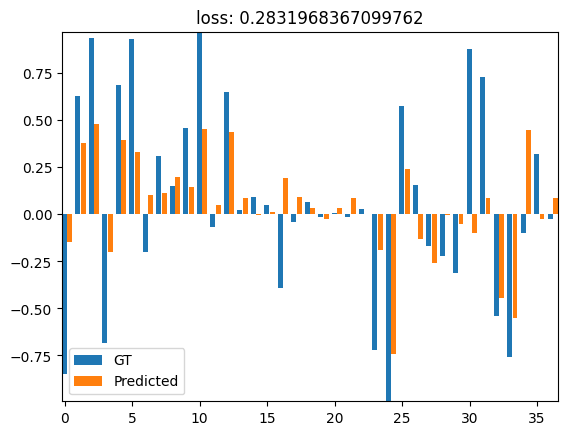

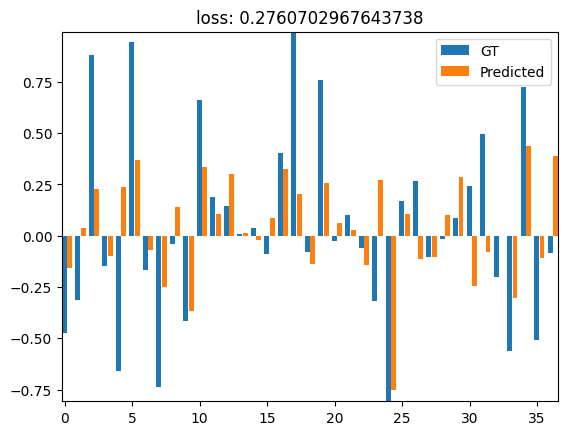

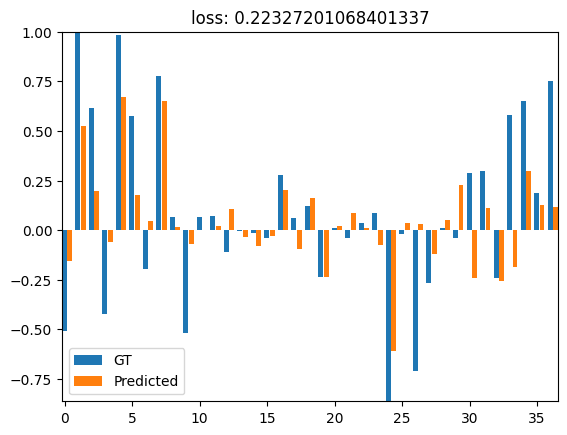

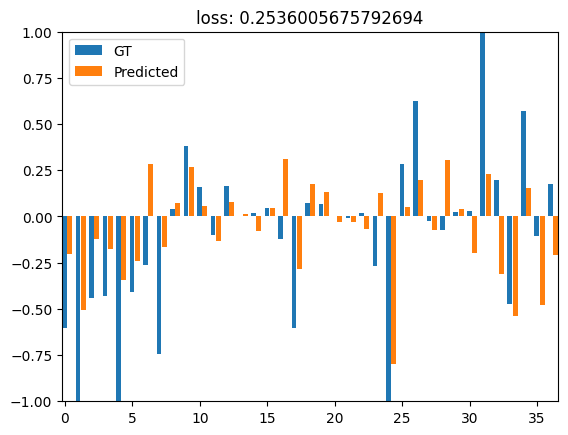

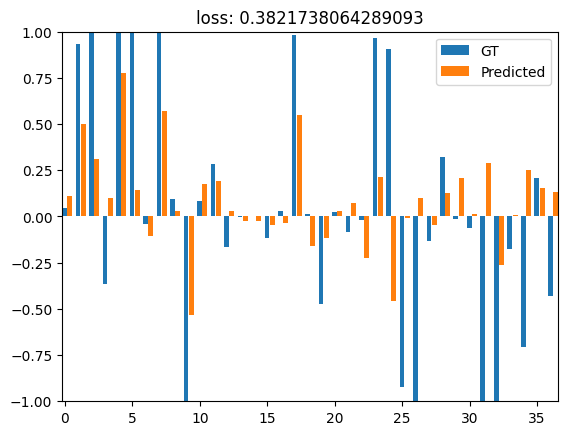

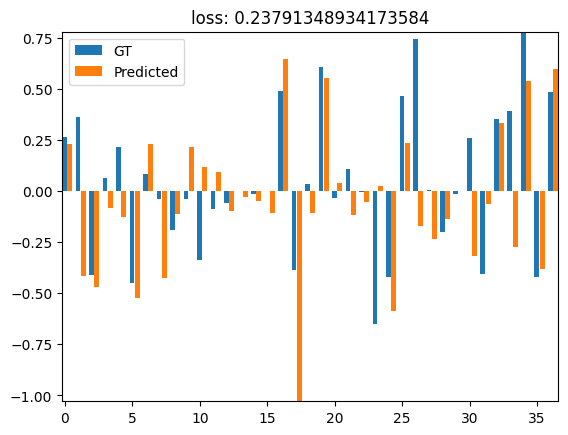

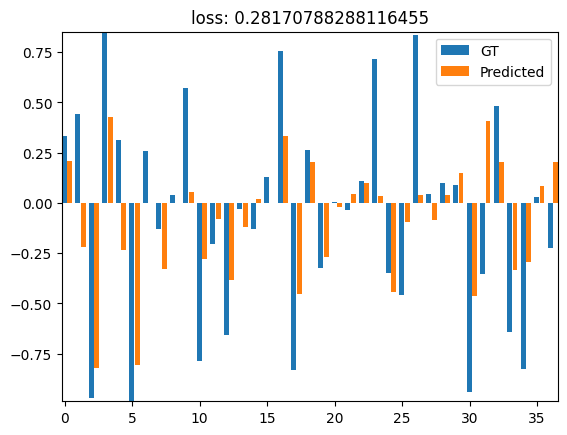

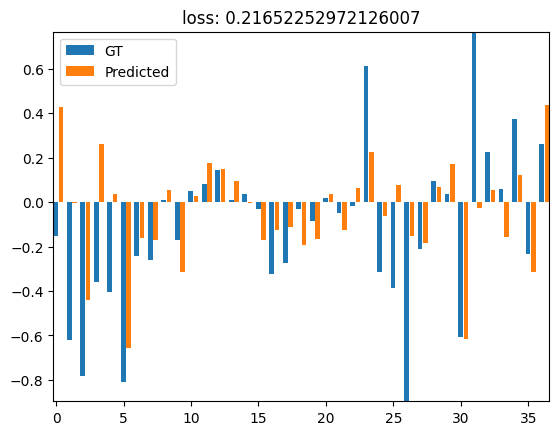

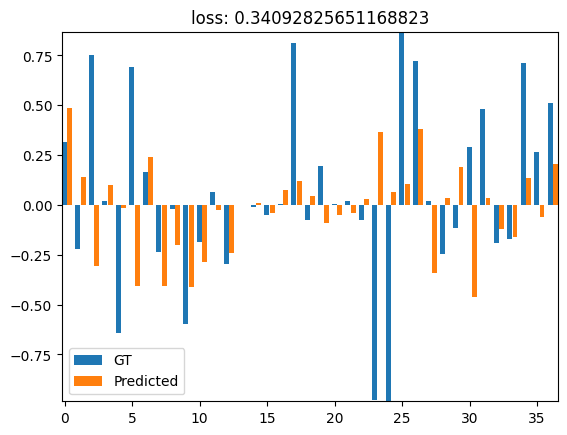

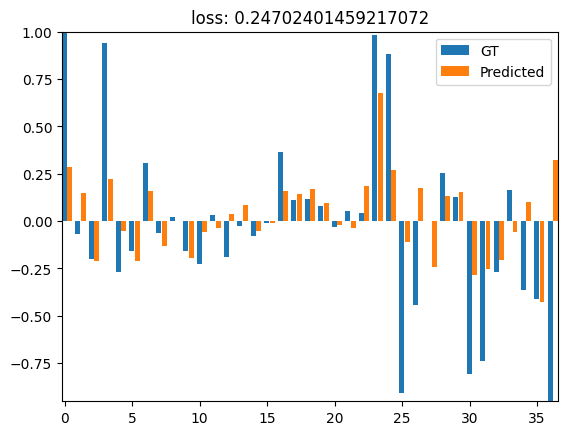

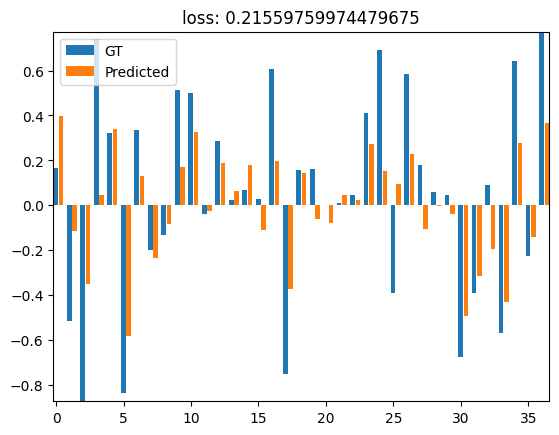

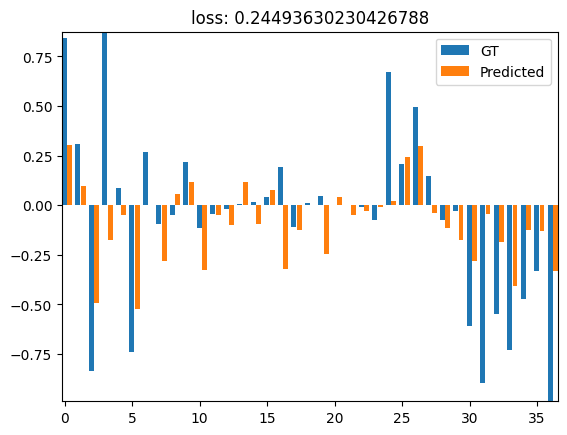

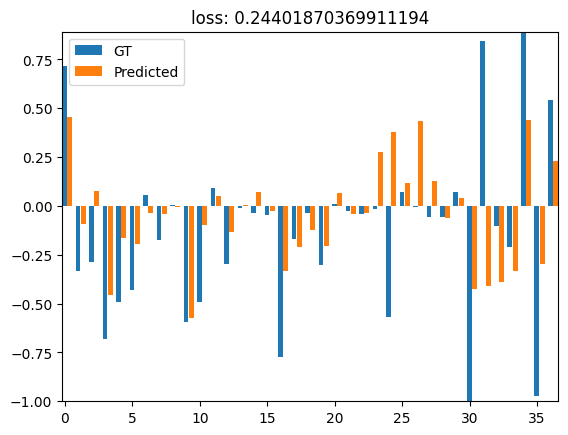

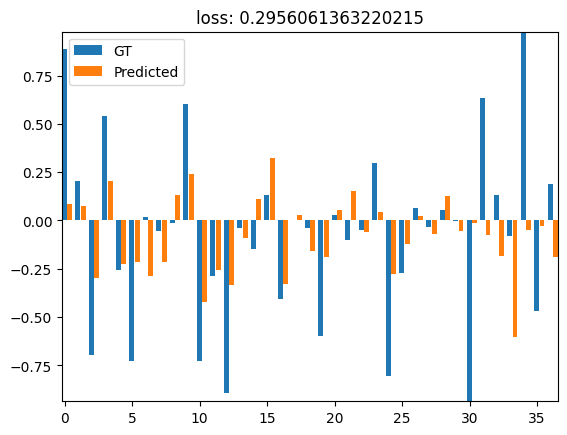

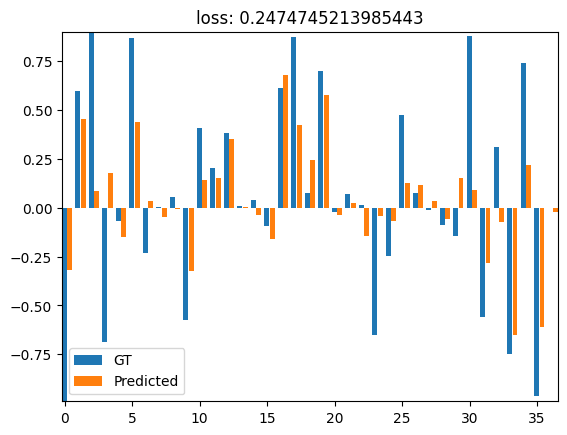

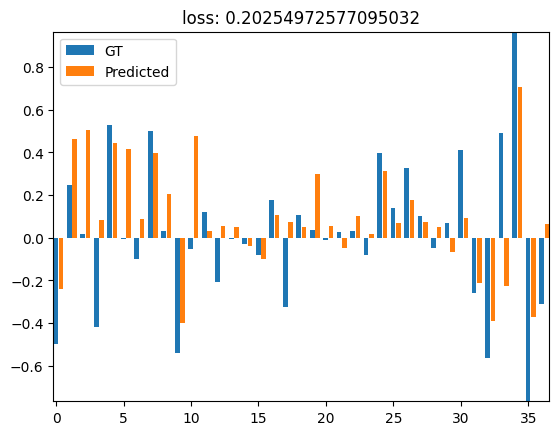

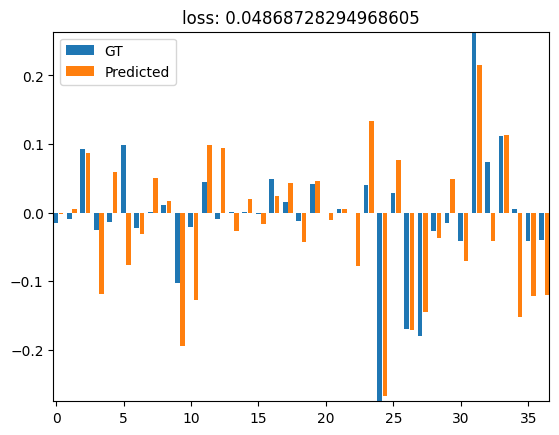

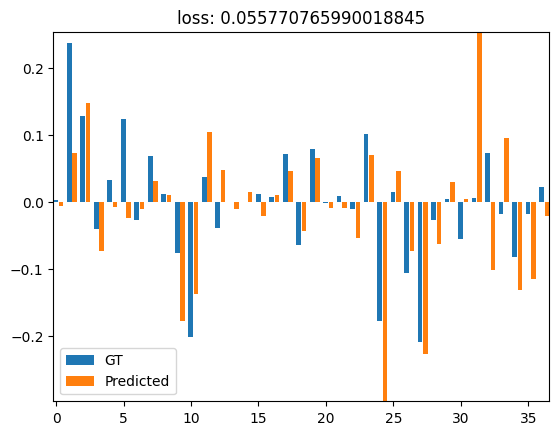

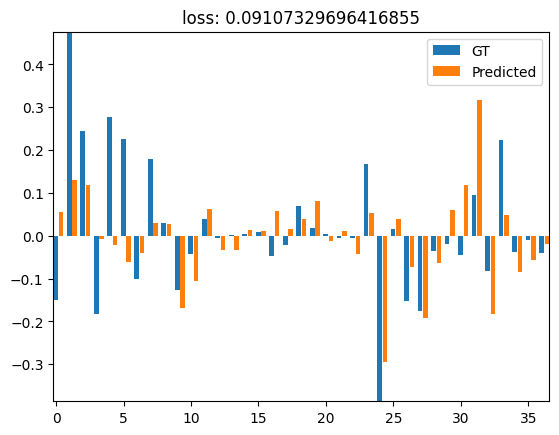

In [11]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPL',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=False)
env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

image_list = []
for t in np.arange(130,315):
    rp = root_pos[50*t]
    rr = root_rot[50*t]
    rv = root_vel[50*t]
    rw = root_ang_vel[50*t]
    qpos = dof_pos[50*t]
    qvel = dof_vel[50*t]
#     print(rr[0])
    env.data.qvel = torch.cat((rv, rw, qvel))
    env.forward(torch.cat((rp, rr, qpos)))
    for h in range(horizon):
        ctrl = action[50*t+h]
        pred_ctrl, _, _, _ = policy(obs[50*t+h])
        
        env.step(ctrl.detach().numpy())
        if env.loop_every(tick_every=1):
            # Plot world frame
            env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                    PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
            env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                    PLOT_AXIS=False,label="tick:[%d]"%(env.tick))

            # # Stand
            # for p_GT in GT['xpos'][int(t+h)]:
            #     env.plot_sphere(p=p_GT,r=0.02,rgba=[1,0.2,0.2,1])
            
            env.render()

            # if SAVE_VID:
            #     # Save iamges
            #     png_path = '../temp/smplrig_MPC_%05d.png'%(env.tick)
            #     create_folder_if_not_exists(png_path)
            #     image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
            #     cv2.imwrite(png_path,image)
            if PLOT:
                fig, ax = plt.subplots()
                ax.bar(np.arange(action_dim)-0.2, ctrl, width = 0.35, align='edge', label='GT')
                ax.bar(np.arange(action_dim)+0.2, pred_ctrl.detach(), width = 0.35, align='edge', label='Predicted')
                ax.set_title("loss: {}".format(
                    torch.mean(torch.abs(ctrl-pred_ctrl.detach()))
                ))
                ax.legend()
                ax.margins(0)
                fig.canvas.draw()

                image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                image_list.append(image_from_plot)


In [ ]:
file_name = "240312_walk_keypos.pth"
torch.save(policy.state_dict(), file_name)

In [ ]:
policy.state_dict()